In [1]:
import cv2
import sys
from matplotlib import pyplot as plt 
import numpy as np
import sklearn
from collections import deque

print(cv2.__version__)
print(np.__version__)
print(sklearn.__version__)

4.4.0
1.17.2
0.23.2


In [2]:
grayFakeFaceC = cv2.cvtColor(cv2.imread("./test/fake_center.png"), cv2.COLOR_BGR2GRAY)
grayFakeFaceL = cv2.cvtColor(cv2.imread("./test/fake_left.png"), cv2.COLOR_BGR2GRAY)
grayFakeFaceR = cv2.cvtColor(cv2.imread("./test/fake_right.png"), cv2.COLOR_BGR2GRAY)

fakeFace = [grayFakeFaceC, grayFakeFaceL, grayFakeFaceR]

grayRealFaceC = cv2.cvtColor(cv2.imread("./test/real_center.png"), cv2.COLOR_BGR2GRAY)
grayRealFaceL = cv2.cvtColor(cv2.imread("./test/real_left.png"), cv2.COLOR_BGR2GRAY)
grayRealFaceR = cv2.cvtColor(cv2.imread("./test/real_right.png"), cv2.COLOR_BGR2GRAY)

fakeFace = [grayFakeFaceC, grayFakeFaceL, grayFakeFaceR]

In [3]:
def matches(img1, img2):   
    my_SIFT_instance = cv2.SIFT_create()
    kp1, des1 = my_SIFT_instance.detectAndCompute(img1,None)
    kp2, des2 = my_SIFT_instance.detectAndCompute(img2,None)
    lowes = cv2.FlannBasedMatcher(dict(algorithm = 0, trees = 5), dict(checks=50)).knnMatch(des1,des2,k=2)
    
    leftPoints, rightPoints = [], []
    for m, n in lowes:  
        if (m.distance/n.distance) < 0.8:
            rightPoints.append(kp2[m.trainIdx].pt)
            leftPoints.append(kp1[m.queryIdx].pt)
            
    leftPoints, rightPoints = np.int32(leftPoints), np.int32(rightPoints)
    fundMatrix, mask = cv2.findFundamentalMat(leftPoints, rightPoints, cv2.FM_RANSAC)
    print(len(leftPoints),len(rightPoints))
    width, height = img1.shape[:2]
    success ,homo1, homo2 = cv2.stereoRectifyUncalibrated(leftPoints, rightPoints, fundMatrix, img1.shape[:2])

    imgMatch1 = cv2.warpPerspective(img1, homo1, (height, width))
    imgMatch2 = cv2.warpPerspective(img2, homo2, (height, width))
    
    return imgMatch1, imgMatch2

213 213
14 14


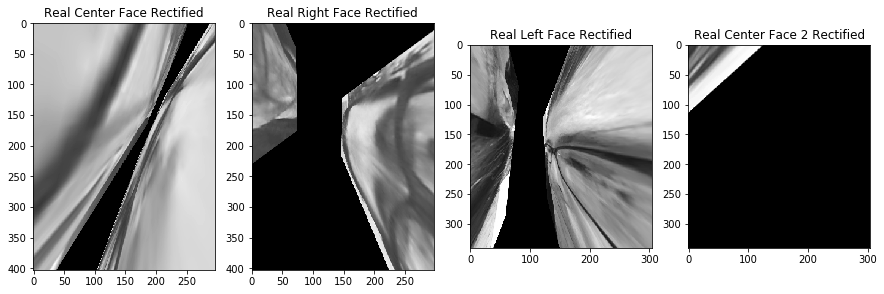

In [4]:
# realLeftMatch, realRightMatch = matches(grayRealFaceL, grayRealFaceR)

# plt.figure(figsize=(15,15))
# plt.subplot(1, 2, 1)
# plt.title("Left Tape Rectified")
# plt.imshow(realLeftMatch, cmap = 'gray')
# plt.subplot(1, 2, 2)
# plt.title("Left Coasters Rectified")
# plt.imshow(realRightMatch, cmap = 'gray')

# resized1, resized2 = resize(grayRealFaceL, grayRealFaceR)
realCenMatch, realRightMatch = matches(grayFakeFaceC, grayFakeFaceL)
realCen2Match, realLeftMatch = matches(grayRealFaceR, grayRealFaceL)


plt.figure(figsize=(15,15))
plt.subplot(1, 4, 1)
plt.title("Real Center Face Rectified")
plt.imshow(realCenMatch, cmap = 'gray')
plt.subplot(1, 4, 2)
plt.title("Real Right Face Rectified")
plt.imshow(realRightMatch, cmap = 'gray')
plt.subplot(1, 4, 3)
plt.title("Real Left Face Rectified")
plt.imshow(realLeftMatch, cmap = 'gray')
plt.subplot(1, 4, 4)
plt.title("Real Center Face 2 Rectified")
plt.imshow(realCen2Match, cmap = 'gray')


## START NEW

## Haar Cascade Face Finder Class

In [ ]:
from __future__ import print_function
import cv2
import argparse


class FaceFinder:
    def __init__(self, path) -> None:

        # load frontal face detector files
        cv2.samples.addSamplesDataSearchPath(path)
        front_face_cascade_name = "haarcascade_frontalface_default.xml"

        # load frontal alt detector files
        cv2.samples.addSamplesDataSearchPath(path)
        alt_face_cascade_name = "haarcascade_frontalface_alt.xml"

        # load frontal alt2 detector files
        cv2.samples.addSamplesDataSearchPath(path)
        alt2_face_cascade_name = "haarcascade_frontalface_alt2.xml"

        # load frontal profile detector files
        cv2.samples.addSamplesDataSearchPath(path)
        profile_face_cascade_name = "haarcascade_profileface.xml"

        # create and load the frontal face cascade
        self.frontal_face_cascade = cv2.CascadeClassifier()
        if not self.frontal_face_cascade.load(
            cv2.samples.findFile(front_face_cascade_name)
        ):
            print("--(!)Error loading frontal face cascade")
            exit(0)

        # create and load the alt face cascade
        self.alt_face_cascade = cv2.CascadeClassifier()
        if not self.alt_face_cascade.load(cv2.samples.findFile(alt_face_cascade_name)):
            print("--(!)Error loading alt face cascade")
            exit(0)

        # create and load the alt2 face cascade
        self.alt2_face_cascade = cv2.CascadeClassifier()
        if not self.alt2_face_cascade.load(
            cv2.samples.findFile(alt2_face_cascade_name)
        ):
            print("--(!)Error loading alt2 face cascade")
            exit(0)

        # create and load the profile face cascade
        self.profile_face_cascade = cv2.CascadeClassifier()
        if not self.profile_face_cascade.load(
            cv2.samples.findFile(profile_face_cascade_name)
        ):
            print("--(!)Error loading profile face cascade")
            exit(0)

    def ultimate_find_face(self, frame):
        face = self.find_frontal_face(frame)
        if face is not None:
            return face
        face = self.find_alt_face(frame)
        if face is not None:
            return face
        face = self.find_alt2_face(frame)
        if face is not None:
            return face
        face = self.find_profile_face(frame)
        return face

    def find_frontal_face(self, frame):
        # get the first face in the image
        faces = self.frontal_face_cascade.detectMultiScale(frame)
        if len(faces) == 0:
            return None
        face = self.frontal_face_cascade.detectMultiScale(frame)[0]
        x, y, width, height = face

        # crop the picture so it only includes that face
        face = frame[y : y + height, x : x + width]
        return face

    def find_alt_face(self, frame):
        # get the first face in the image
        faces = self.alt_face_cascade.detectMultiScale(frame)
        if len(faces) == 0:
            return None
        face = self.alt_face_cascade.detectMultiScale(frame)[0]
        x, y, width, height = face

        # crop the picture so it only includes that face
        face = frame[y : y + height, x : x + width]
        return face

    def find_alt2_face(self, frame):
        # get the first face in the image
        faces = self.alt2_face_cascade.detectMultiScale(frame)
        if len(faces) == 0:
            return None
        face = self.alt2_face_cascade.detectMultiScale(frame)[0]
        x, y, width, height = face

        # crop the picture so it only includes that face
        face = frame[y : y + height, x : x + width]
        return face

    def find_profile_face(self, frame):
        # get the first face in the image
        faces = self.profile_face_cascade.detectMultiScale(frame)
        if len(faces) == 0:
            return None
        face = self.profile_face_cascade.detectMultiScale(frame)[0]
        x, y, width, height = face

        # crop the picture so it only includes that face
        face = frame[y : y + height, x : x + width]
        return face

    def detect_triplet(self, triplet):
        center, left, right = triplet
        center_face = self.ultimate_find_face(center)
        left_face = self.ultimate_find_face(left)
        right_face = self.ultimate_find_face(right)
        return [
            center_face,
            left_face,
            right_face,
        ]


In [ ]:
def import_dataset():
    # initiate img types and path
    img_types = ["C", "L", "R"]
    data_path = "Final_Project/dataset/"

    real_imgs = [
        [cv2.imread(f"{data_path}real/{i}{t}r.jpg") for t in img_types]
        for i in range(1, 12 + 1)
    ]
    fake_imgs = [
        [cv2.imread(f"{data_path}fake/{i}{t}f.jpg") for t in img_types]
        for i in range(1, 12 + 1)
    ]
    return real_imgs, fake_imgs

In [ ]:
def train():
    # load the dataset
    real_imgs, fake_imgs = import_dataset()

    # find the faces in all images
    path = "Final_Project/res"
    face_finder = FaceFinder(path)

    real_faces = [face_finder.detect_triplet(triplet) for triplet in real_imgs]
    fake_faces = [face_finder.detect_triplet(triplet) for triplet in fake_imgs]